## Setup Environment

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# !pip install tensorflow-determinism
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 5.2 MB/s 
     |████████████████████████████████| 1.6 MB 47.7 MB/s 


In [ ]:
from pathlib import Path
import pathlib

selected_three_bands = [1, 2, 3] # Band info: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/bands/
resized_img_shape = (224, 224, 3)

project_folder = Path('/content/drive/MyDrive/Dengue forecasting with Satellite Images')
new_project_folder = Path('/content/drive/MyDrive/Prediction of Dengue Outbreak with Satellite Imagery')
dataset_folder = new_project_folder / 'dataset'
img_folder = dataset_folder / 'image/10_cities'
csv_folder = dataset_folder / 'csv/81 city'
pretrain_model = 'MobileNetV2'
lstm_week = 10

cities =  {
  "76001":	"Cali",
  "05001":	"Medellín",
  "50001":	"Villavicencio",
  "54001":	"Cúcuta",
  "73001":	"Ibagué",
  "68001":	"Bucaramanga",
  "05360":	"Itagüí",
  "08001":	"Barranquilla",
  "41001":	"Neiva",
  "23001":	"Montería"
}

In [ ]:
import logging
import pickle
import unicodedata
from PIL import Image
import PIL
import os
import numpy as np
import tensorflow as tf
import random
import time
import keras_tuner
import glob
import scipy.stats as st
import scipy
import cv2
import pandas as pd
import seaborn as sns

from skimage import io
import skimage
from skimage.transform import resize 
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure
import IPython.core.pylabtools as pylabtools
from IPython.core.pylabtools import figsize

from tensorflow import keras
from tensorflow.keras import layers
tf.get_logger().setLevel('ERROR')
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [ ]:
!pip install epiweeks
import epiweeks
from epiweeks import Week, Year
from datetime import date

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Functions

In [ ]:
def checkFolder(folder_path):
  if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [ ]:
def get_resized_rgb_band(origin_img, selected_three_bands, resized_img_shape):
  selected_img = np.stack((origin_img[:, :, selected_three_bands[0]], 
                           origin_img[:, :, selected_three_bands[1]], 
                           origin_img[:, :, selected_three_bands[2]]))
  selected_img = np.transpose(selected_img, (1, 2, 0))
  selected_img = resize(selected_img, resized_img_shape, preserve_range=True, anti_aliasing=True)
  return selected_img

In [ ]:
def cnn_input_preprocess(img_ls, pretrain_model):
  if pretrain_model == 'MobileNetV2': # minimum size & parameters
    img_ls = tf.keras.applications.mobilenet_v2.preprocess_input(img_ls)
  elif pretrain_model == 'EfficientNetV2L': # best top 5 acc
    img_ls = tf.keras.applications.efficientnet_v2.preprocess_input(img_ls)
  elif pretrain_model == 'VGG16': # min depth
    img_ls = tf.keras.applications.vgg16.preprocess_input(img_ls)
  elif pretrain_model == 'ResNet50V2':
    img_ls = tf.keras.applications.resnet_v2.preprocess_input(img_ls)
  return img_ls

## Load Data

### Prec

In [ ]:
prec_dic = {}
prec_df = pd.read_csv(csv_folder / "precipitation_all.csv")
prec_df = prec_df.replace(np.nan,0)
prec_df = prec_df.loc[prec_df['LastDayWeek'] >= '2016-01-03']
prec_df = prec_df.loc[prec_df['LastDayWeek'] < '2019-01-01']
print(len(prec_df))

for city_code in cities:
  col_name = 'precipitation_' +  city_code
  selected_df = prec_df[col_name]
  prec_dic[city_code] = selected_df.tolist()

156


### Temp

In [ ]:
temp_dic = {}
temp_df = pd.read_csv(csv_folder / "temperature_all_no_missing.csv")
temp_df = temp_df.loc[temp_df['LastDayWeek'] > '2016-01-03']
temp_df = temp_df.loc[temp_df['LastDayWeek'] < '2019-01-01']
temp_df = temp_df.sort_values('LastDayWeek')
print(temp_df.keys())

for city_code in cities:
  col_name = 'temperature_' +  city_code
  selected_df = temp_df[col_name]
  print(len(selected_df))
  temp_dic[city_code] = selected_df.tolist()

Index(['LastDayWeek', 'temperature_76001', 'temperature_54001',
       'temperature_50001', 'temperature_73001', 'temperature_68001',
       'temperature_41001', 'temperature_23001', 'temperature_05001',
       'temperature_05360', 'temperature_08001'],
      dtype='object')
156
156
156
156
156
156
156
156
156
156


### Cases

201601 201852
Index(['Unnamed: 0', 'epiweek', 'Cases', 'Municipality code', 'Municipality',
       'cases_differences', 'cases_intensity', 'cases_diff_abs',
       'Stability Label', 'final_cases_label'],
      dtype='object')
====== 76001 Cali ======
Stable       127
Decreased     17
Increased     12
Name: final_cases_label, dtype: int64
201601 201852
====== 05001 Medellín ======
Stable       113
Decreased     23
Increased     20
Name: final_cases_label, dtype: int64
201601 201852
====== 50001 Villavicencio ======
Stable       97
Increased    31
Decreased    28
Name: final_cases_label, dtype: int64
201601 201852
====== 54001 Cúcuta ======
Stable       121
Increased     20
Decreased     15
Name: final_cases_label, dtype: int64
201601 201852
====== 73001 Ibagué ======
Stable       104
Decreased     29
Increased     23
Name: final_cases_label, dtype: int64
201601 201852
====== 68001 Bucaramanga ======
Stable       90
Increased    34
Decreased    32
Name: final_cases_label, dtype: int64
2

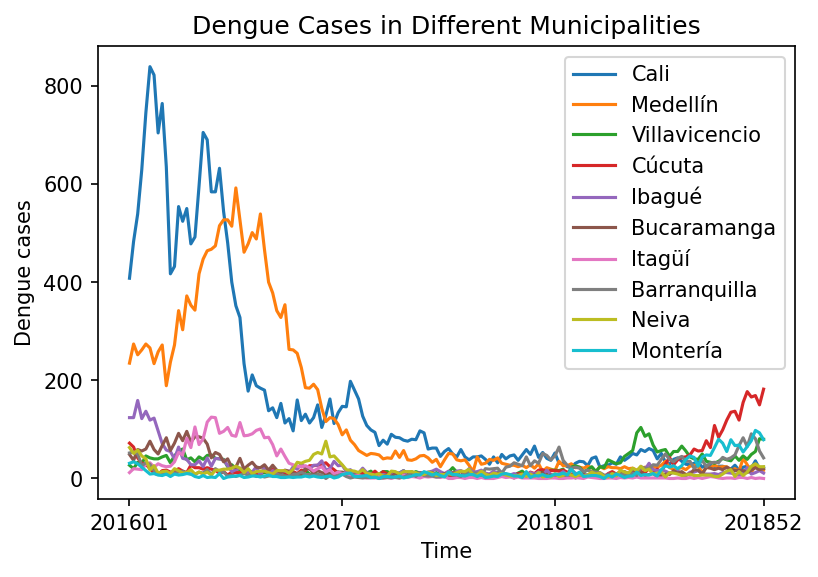

In [ ]:
all_city_case = {}
case_df = pd.read_csv(csv_folder / 'Label_CSV_All_Municipality.csv')
case_df['Municipality'] = case_df['Municipality'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
case_df['epiweek'] = case_df['epiweek'].str.replace('/w','')
print(min(case_df['epiweek']), max(case_df['epiweek']))
print(case_df.columns)
save_together = True
city_ls = []
plt.figure(dpi=150)

for city_code in cities:
  print('======', city_code, cities[city_code], '======')
  selected_df = case_df[case_df['Municipality code'] == int(city_code)].sort_values('epiweek')
  print(selected_df["final_cases_label"].value_counts())
  selected_df = pd.get_dummies(selected_df, columns=["final_cases_label"], prefix=["Case_Label"] )
  all_city_case[city_code] = selected_df[["Case_Label_Decreased", "Case_Label_Increased", "Case_Label_Stable"]].to_numpy()
  print(min(selected_df['epiweek']), max(selected_df['epiweek']))
  plt.plot(selected_df['epiweek'], selected_df['Cases'], label=cities[city_code])
  plt.xticks([0, 52, 52*2, 52*3-1])

plt.legend()
plt.xlabel('Time')
plt.ylabel('Dengue cases')
plt.title('Dengue Cases in Different Municipalities')
plt.xticks([0, 52, 52*2, 52*3-1])
plt.show()

### Image

In [ ]:
all_city_img_dic = {}

for city_code in os.listdir(img_folder):
  X, y = list(), list()
  all_img_dic = {}
  print(city_code, img_folder)
  sorted_img_paths = sorted((Path(img_folder) / city_code).glob("*.*"))
  for img_name in sorted_img_paths: # Iterate through sorted samples
    img_name = str(img_name.name)
    if '2015' in img_name:
      continue
    origin_img = io.imread(os.path.join(img_folder, city_code, img_name)) # Load image
    height, width, _ = origin_img.shape
    print(img_name, origin_img.shape)
    resized_rgb_img = get_resized_rgb_band(origin_img, selected_three_bands, resized_img_shape)
    all_img_dic[img_name] = resized_rgb_img

  all_city_img_dic[city_code] = all_img_dic

23001 /content/drive/MyDrive/Prediction of Dengue Outbreak with Satellite Imagery/dataset/image/10_cities
image_2016-01-03.tiff (744, 748, 12)
image_2016-01-10.tiff (747, 746, 12)
image_2016-01-17.tiff (749, 743, 12)
image_2016-01-24.tiff (744, 748, 12)
image_2016-01-31.tiff (744, 748, 12)
image_2016-02-07.tiff (744, 748, 12)
image_2016-02-14.tiff (744, 748, 12)
image_2016-02-21.tiff (749, 743, 12)
image_2016-02-28.tiff (744, 748, 12)
image_2016-03-06.tiff (744, 748, 12)
image_2016-03-13.tiff (749, 743, 12)
image_2016-03-20.tiff (745, 747, 12)
image_2016-03-27.tiff (749, 743, 12)
image_2016-04-03.tiff (744, 748, 12)
image_2016-04-10.tiff (749, 743, 12)
image_2016-04-17.tiff (749, 743, 12)
image_2016-04-24.tiff (749, 743, 12)
image_2016-05-01.tiff (745, 747, 12)
image_2016-05-08.tiff (744, 748, 12)
image_2016-05-15.tiff (749, 743, 12)
image_2016-05-22.tiff (746, 746, 12)
image_2016-05-29.tiff (749, 743, 12)
image_2016-06-05.tiff (744, 748, 12)
image_2016-06-12.tiff (744, 748, 12)
image_

# Model Experiments

## Functions

In [ ]:
# weighted code:
# n_zeros = (weekly_case_label[:, 0] == 1).sum()
# n_ones = n_zeros = (weekly_case_label[:, 1] == 1).sum()
# n_twos = n_zeros = (weekly_case_label[:, 2] == 1).sum()
# n_total = n_zeros + n_ones
# weights = {0: n_total/n_zeros, 1: n_total/n_ones, 2: n_total/n_twos}
# print(f'zeros: {n_zeros}, ones: {n_ones}, total: {n_total}')

# prediction:
# y_train_pred, y_test_pred = model.predict(X_train), model.predict(X_test)
# y_train_pred, y_test_pred = np.argmax(y_train_pred, 1).reshape(-1, 1), np.argmax(y_test_pred, 1).reshape(-1, 1)
# y_pred = np.concatenate((y_train_pred, y_test_pred), axis=None)
# print("Predict:", y_test_pred.flatten())
# print("True:", multi_class_label[train_num:])
# plt.scatter(range(len(y_pred)), y_pred, label="pred")
# plt.scatter(range(len(multi_class_label)), multi_class_label, label="true")
# plt.legend()
# plt.show()


# History    
# plt.plot(history.history['loss'], label="train loss")
# plt.plot(history.history['val_loss'], label="val loss")
# plt.legend()
# plt.show()

# plt.plot(history.history['auc'], label="train auc")
# plt.plot(history.history['val_auc'], label="val auc")
# plt.legend()
# plt.show()
# multi_class_label = np.argmax(weekly_case_label,1)

In [ ]:
def mobileNetNoTimeSeries(metrics):
  model = keras.Sequential()
  cnn = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet', classes=1000)
  for idx, layer in enumerate(cnn.layers):
    layer.trainable = idx > len(cnn.layers) - 2
  model.add(cnn)
  model.add(layers.Dense(3, activation='softmax'))
  opt = keras.optimizers.Adam(learning_rate=0.005)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=metrics)
  return model

In [ ]:
def evaluate(model, x, y, verbose=None):
  if verbose:
    print('Evaluate: ')
  result = model.evaluate(x, y)
  stored_results = {}
  for i, metric in enumerate(model.metrics_names):
    stored_results[metric] = result[i]
    if verbose:
      print(f'{metric}: {result[i]}')
  return stored_results

In [ ]:
city_weights = {}
for city_code in os.listdir(img_folder): 
  if city_code not in cities.keys():
    continue
  print('=========================================== ' + cities[city_code] + ' ===========================================')
  resized_img_ls = all_city_img_dic[city_code]
  resized_satellite_imgs = np.array(list(resized_img_ls.values()))
  weekly_case_label = np.array(all_city_case[city_code])
  resized_satellite_imgs = cnn_input_preprocess(resized_satellite_imgs, pretrain_model)
  n_zeros = (weekly_case_label[:, 0] == 1).sum()
  n_ones = n_zeros = (weekly_case_label[:, 1] == 1).sum()
  n_twos = n_zeros = (weekly_case_label[:, 2] == 1).sum()
  n_total = n_zeros + n_ones
  weights = {0: n_total/n_zeros, 1: n_total/n_ones, 2: n_total/n_twos}
  city_weights[city_code] = weights 
  print(f'zeros: {n_zeros}, ones: {n_ones}, total: {n_total}')

=========================================== Montería ===========================================
zeros: 110, ones: 24, total: 134
=========================================== Ibagué ===========================================
zeros: 104, ones: 23, total: 127
=========================================== Neiva ===========================================
zeros: 105, ones: 26, total: 131
=========================================== Bucaramanga ===========================================
zeros: 90, ones: 34, total: 124
=========================================== Cúcuta ===========================================
zeros: 121, ones: 20, total: 141
=========================================== Villavicencio ===========================================
zeros: 97, ones: 31, total: 128
=========================================== Cali ===========================================
zeros: 127, ones: 12, total: 139
=========================================== Medellín ==========================================

## MobileNet

#### No weight

In [ ]:
train_num = int(156 * 0.8)
metrics = {
    "auc": [],
    "acc": [],
    "entropy": []
}
selected_metrics = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.CategoricalAccuracy(name='acc'),
    tf.keras.metrics.CategoricalCrossentropy(name='entropy')
] 

for city_code in os.listdir(img_folder): 
  if city_code not in cities.keys():
    continue
  print('=========================================== ' + cities[city_code] + ' ===========================================')
  resized_img_ls = all_city_img_dic[city_code]
  resized_satellite_imgs = np.array(list(resized_img_ls.values()))
  weekly_case_label = np.array(all_city_case[city_code])
  resized_satellite_imgs = cnn_input_preprocess(resized_satellite_imgs, pretrain_model)

  weekly_case_label = np.array(all_city_case[city_code])
  multi_class_label = np.argmax(weekly_case_label,1)

  X_train, X_test = resized_satellite_imgs[:train_num], resized_satellite_imgs[train_num:] 
  y_train, y_test = weekly_case_label[:train_num], weekly_case_label[train_num:] 
  model = mobileNetNoTimeSeries(selected_metrics)

  for i in range(3):
    callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0,
                        validation_data=(X_test, y_test), callbacks=[callback])

    stored_results = evaluate(model, X_test, y_test)
    for key in metrics.keys():
      metrics[key].append(stored_results[key])

  for key in metrics.keys():
    three_trial_results = metrics[key]
    print(key, f": {np.average(three_trial_results):.3f}±{np.std(three_trial_results):.3f}")

=========================================== Montería ===========================================
1/1 [==============================] - 0s 57ms/step - loss: 1.8536 - auc: 0.4170 - acc: 0.2812 - entropy: 1.8536
auc : 0.456±0.030
acc : 0.281±0.000
entropy : 1.657±0.180
=========================================== Ibagué ===========================================
1/1 [==============================] - 0s 53ms/step - loss: 0.6795 - auc: 0.8508 - acc: 0.7812 - entropy: 0.6795
auc : 0.653±0.198
acc : 0.531±0.250
entropy : 1.174±0.500
=========================================== Neiva ===========================================
1/1 [==============================] - 0s 55ms/step - loss: 0.9991 - auc: 0.7861 - acc: 0.6250 - entropy: 0.9991
auc : 0.692±0.171
acc : 0.562±0.209
entropy : 1.104±0.420
=========================================== Bucaramanga ===========================================
1/1 [==============================] - 0s 56ms/step - loss: 0.9415 - auc: 0.7654 - acc: 0.6250 - entr

#### With weights

In [ ]:
# with weights
train_num = int(156 * 0.8)
metrics = {
    "auc": [],
    "acc": [],
    "entropy": []
}
selected_metrics = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.CategoricalAccuracy(name='acc'),
    tf.keras.metrics.CategoricalCrossentropy(name='entropy')
] 

for city_code in os.listdir(img_folder): 
  if city_code not in cities.keys():
    continue
  print('=========================================== ' + cities[city_code] + ' ===========================================')
  resized_img_ls = all_city_img_dic[city_code]
  resized_satellite_imgs = np.array(list(resized_img_ls.values()))
  weekly_case_label = np.array(all_city_case[city_code])
  resized_satellite_imgs = cnn_input_preprocess(resized_satellite_imgs, pretrain_model)

  weekly_case_label = np.array(all_city_case[city_code])
  multi_class_label = np.argmax(weekly_case_label,1)

  X_train, X_test = resized_satellite_imgs[:train_num], resized_satellite_imgs[train_num:] 
  y_train, y_test = weekly_case_label[:train_num], weekly_case_label[train_num:] 
  model = mobileNetNoTimeSeries(selected_metrics)

  for i in range(3):
    callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0,
                        validation_data=(X_test, y_test), callbacks=[callback], class_weight=city_weights[city_code])
    
    stored_results = evaluate(model, X_test, y_test)
    for key in metrics.keys():
      metrics[key].append(stored_results[key])

  for key in metrics.keys():
    three_trial_results = metrics[key]
    print(key, f": {np.average(three_trial_results):.3f}±{np.std(three_trial_results):.3f}")

=========================================== Montería ===========================================
1/1 [==============================] - 0s 53ms/step - loss: 1.7035 - auc: 0.4678 - acc: 0.2812 - entropy: 1.7035
auc : 0.469±0.003
acc : 0.281±0.026
entropy : 1.565±0.137
=========================================== Ibagué ===========================================
1/1 [==============================] - 0s 58ms/step - loss: 0.6993 - auc: 0.8645 - acc: 0.6875 - entropy: 0.6993
auc : 0.664±0.195
acc : 0.495±0.215
entropy : 1.152±0.426
=========================================== Neiva ===========================================
1/1 [==============================] - 0s 56ms/step - loss: 0.9883 - auc: 0.7451 - acc: 0.5938 - entropy: 0.9883
auc : 0.690±0.163
acc : 0.528±0.181
entropy : 1.091±0.359
=========================================== Bucaramanga ===========================================
1/1 [==============================] - 0s 56ms/step - loss: 1.1503 - auc: 0.7185 - acc: 0.5000 - entr

## Temp + Prec

#### No weights

In [ ]:
# Temp + Prec -> Case
metrics = {
    "auc": [],
    "acc": [],
    "entropy": []
}

selected_metrics = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.CategoricalAccuracy(name='acc'),
    tf.keras.metrics.CategoricalCrossentropy(name='entropy')
] 

train_set = int(156 * 0.8) 
for city_code in cities.keys():
  if city_code not in cities.keys():
    continue
  print('=========================================== ' + cities[city_code] + ' ===========================================')
  X = np.stack((prec_dic[city_code], temp_dic[city_code]), axis=1)
  y = np.array(all_city_case[city_code])
  print(X.shape, y.shape)
  multi_class_label = np.argmax(weekly_case_label,1)
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(50, activation='relu'),
      tf.keras.layers.Dense(3, activation='sigmoid')
    ])
  model.add(layers.Dense(3, activation='softmax'))
  opt = keras.optimizers.Adam(learning_rate=0.005)
  callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=selected_metrics)
  for i in range(3):
    history = model.fit(X[:train_set], y[:train_set], epochs=20, batch_size=32, verbose=0,
                        validation_data=(X[train_set:], y[train_set:]), callbacks=[callback])
    stored_results = evaluate(model, X[train_set:], y[train_set:])
    for key in metrics.keys():
      metrics[key].append(stored_results[key])
        
  for key in metrics.keys():
    three_trial_results = metrics[key]
    print(key, f": {np.average(three_trial_results):.3f}±{np.std(three_trial_results):.3f}")

=========================================== Cali ===========================================
(156, 2) (156, 3)
1/1 [==============================] - 0s 24ms/step - loss: 0.2714 - auc: 1.0000 - acc: 1.0000 - entropy: 0.2714
auc : 1.000±0.000
acc : 1.000±0.000
entropy : 0.362±0.102
=========================================== Medellín ===========================================
(156, 2) (156, 3)
1/1 [==============================] - 0s 24ms/step - loss: 0.5456 - auc: 0.9312 - acc: 0.9062 - entropy: 0.5456
auc : 0.967±0.033
acc : 0.953±0.047
entropy : 0.443±0.109
=========================================== Villavicencio ===========================================
(156, 2) (156, 3)
1/1 [==============================] - 0s 26ms/step - loss: 1.2992 - auc: 0.5469 - acc: 0.3750 - entropy: 1.2992
auc : 0.827±0.200
acc : 0.760±0.275
entropy : 0.727±0.412
=========================================== Cúcuta ===========================================
(156, 2) (156, 3)
1/1 [=======================

#### With weights

In [ ]:
# Temp + Prec -> Case
metrics = {
    "auc": [],
    "acc": [],
    "entropy": []
}

selected_metrics = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.CategoricalAccuracy(name='acc'),
    tf.keras.metrics.CategoricalCrossentropy(name='entropy')
] 

train_set = int(156 * 0.8) 
for city_code in cities.keys():
  if city_code not in cities.keys():
    continue
  print('=========================================== ' + cities[city_code] + ' ===========================================')
  X = np.stack((prec_dic[city_code], temp_dic[city_code]), axis=1)
  y = np.array(all_city_case[city_code])
  print(X.shape, y.shape)
  multi_class_label = np.argmax(weekly_case_label,1)
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(50, activation='relu'),
      tf.keras.layers.Dense(3, activation='sigmoid')
    ])
  model.add(layers.Dense(3, activation='softmax'))
  opt = keras.optimizers.Adam(learning_rate=0.005)
  callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=selected_metrics)
  for i in range(3):
    history = model.fit(X[:train_set], y[:train_set], epochs=20, batch_size=32, verbose=0,
                        validation_data=(X[train_set:], y[train_set:]), callbacks=[callback], class_weight=city_weights[city_code])

    stored_results = evaluate(model, X[train_set:], y[train_set:])
    for key in metrics.keys():
      metrics[key].append(stored_results[key])
        
  for key in metrics.keys():
    three_trial_results = metrics[key]
    print(key, f": {np.average(three_trial_results):.3f}±{np.std(three_trial_results):.3f}")

=========================================== Cali ===========================================
(156, 2) (156, 3)
1/1 [==============================] - 0s 93ms/step - loss: 0.9633 - auc: 0.5000 - acc: 0.0000e+00 - entropy: 0.9633
auc : 0.500±0.000
acc : 0.000±0.000
entropy : 0.958±0.009
=========================================== Medellín ===========================================
(156, 2) (156, 3)
1/1 [==============================] - 0s 26ms/step - loss: 0.9335 - auc: 0.6885 - acc: 0.2812 - entropy: 0.9335
auc : 0.592±0.094
acc : 0.151±0.156
entropy : 0.939±0.037
=========================================== Villavicencio ===========================================
(156, 2) (156, 3)
1/1 [==============================] - 0s 27ms/step - loss: 1.1991 - auc: 0.5469 - acc: 0.3750 - entropy: 1.1991
auc : 0.577±0.080
acc : 0.226±0.165
entropy : 1.025±0.126
=========================================== Cúcuta ===========================================
(156, 2) (156, 3)
1/1 [===================

## MobileNet + LSTM

#### Functions

In [ ]:
def mobileNetWithTimeSeries(metrics):
  lstm_week, input_shape = 10, (224,224,3)
  model = keras.Sequential()
  cnn = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet', classes=1000)
  for idx, layer in enumerate(cnn.layers):
    layer.trainable = idx > len(cnn.layers) - 2

  model.add(keras.layers.TimeDistributed(cnn, input_shape = ((lstm_week,) + input_shape)))
  model.add(layers.LSTM(units=50, dropout=0.1, return_sequences = True))
  model.add(layers.LSTM(units=30, dropout=0.1, return_sequences = True))
  model.add(layers.LSTM(units=15, dropout=0.1, return_sequences = False))
  model.add(layers.Dense(3, activation='softmax'))
  opt = keras.optimizers.Adam(learning_rate=0.005)
  metric = tf.keras.metrics.AUC(name='auc', multi_label=True, num_labels=3)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=metrics)
  return model

In [ ]:
def prepare_image_time_series(input, n_in):
  time_series = []
  for i in range(n_in, len(input)):
    selected_input = input[i-n_in : i]
    time_series.append(selected_input)
  return np.array(time_series)

def getTimeSeries(x, y, ratio=0.8, lstm_week=10):
  print(x.shape, y.shape)
  train_num = int(0.8 * len(x))
  X_train = prepare_image_time_series(x[:train_num], n_in=lstm_week)
  X_test = prepare_image_time_series(x[train_num-lstm_week:], n_in=lstm_week)
  y_train = y[lstm_week:train_num]
  y_test = y[train_num:]
  return X_train, y_train, X_test, y_test 

#### No weight

In [ ]:
train_num = int(156 * 0.8)
metrics = {
    "auc": [],
    "acc": [],
    "entropy": []
}

selected_metrics = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.CategoricalAccuracy(name='acc'),
    tf.keras.metrics.CategoricalCrossentropy(name='entropy')
] 

for city_code in os.listdir(img_folder): 
  if city_code not in cities.keys():
    continue
  print('=========================================== ' + cities[city_code] + ' ===========================================')
  resized_img_ls = all_city_img_dic[city_code]
  resized_satellite_imgs = np.array(list(resized_img_ls.values()))
  weekly_case_label = np.array(all_city_case[city_code])
  resized_satellite_imgs = cnn_input_preprocess(resized_satellite_imgs, pretrain_model)

  weekly_case_label = np.array(all_city_case[city_code])
  multi_class_label = np.argmax(weekly_case_label,1)

  X_img_train, y_train, X_img_test, y_test = getTimeSeries(resized_satellite_imgs, weekly_case_label)
  print(X_img_train.shape, y_train.shape, X_img_test.shape, y_test.shape)
  model = mobileNetWithTimeSeries(selected_metrics)

  for i in range(3):
    callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    history = model.fit(X_img_train, y_train, epochs=20, batch_size=32, verbose=0,
                        validation_data=(X_img_test, y_test), callbacks=[callback])
    stored_results = evaluate(model, X_img_test, y_test)
    for key in metrics.keys():
      metrics[key].append(stored_results[key])
      
  for key in metrics.keys():
    three_trial_results = metrics[key]
    print(key, f": {np.average(three_trial_results):.3f}±{np.std(three_trial_results):.3f}")

=========================================== Montería ===========================================
(156, 224, 224, 3) (156, 3)
(114, 10, 224, 224, 3) (114, 3) (32, 10, 224, 224, 3) (32, 3)
1/1 [==============================] - 0s 300ms/step - loss: 1.9944 - auc: 0.4651 - acc: 0.2812 - entropy: 1.9944
auc : 0.495±0.024
acc : 0.281±0.000
entropy : 1.935±0.126
=========================================== Ibagué ===========================================
(156, 224, 224, 3) (156, 3)
(114, 10, 224, 224, 3) (114, 3) (32, 10, 224, 224, 3) (32, 3)
1/1 [==============================] - 0s 297ms/step - loss: 0.8250 - auc: 0.8452 - acc: 0.7500 - entropy: 0.8250
auc : 0.676±0.181
acc : 0.531±0.251
entropy : 1.344±0.599
=========================================== Neiva ===========================================
(156, 224, 224, 3) (156, 3)
(114, 10, 224, 224, 3) (114, 3) (32, 10, 224, 224, 3) (32, 3)
1/1 [==============================] - 0s 287ms/step - loss: 0.9325 - auc: 0.7263 - acc: 0.6250 - en

#### Weighted Image + LSTM

In [ ]:
train_num = int(156 * 0.8)
metrics = {
    "auc": [],
    "acc": [],
    "entropy": []
}

selected_metrics = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.CategoricalAccuracy(name='acc'),
    tf.keras.metrics.CategoricalCrossentropy(name='entropy')
] 

for city_code in os.listdir(img_folder): 
  if city_code not in cities.keys():
    continue
  print('=========================================== ' + cities[city_code] + ' ===========================================')
  resized_img_ls = all_city_img_dic[city_code]
  resized_satellite_imgs = np.array(list(resized_img_ls.values()))
  weekly_case_label = np.array(all_city_case[city_code])
  resized_satellite_imgs = cnn_input_preprocess(resized_satellite_imgs, pretrain_model)

  weekly_case_label = np.array(all_city_case[city_code])
  multi_class_label = np.argmax(weekly_case_label,1)

  X_img_train, y_train, X_img_test, y_test = getTimeSeries(resized_satellite_imgs, weekly_case_label)
  print(X_img_train.shape, y_train.shape, X_img_test.shape, y_test.shape)
  model = mobileNetWithTimeSeries(selected_metrics)

  for i in range(3):
    callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    history = model.fit(X_img_train, y_train, epochs=20, batch_size=32, verbose=0,
                        validation_data=(X_img_test, y_test), callbacks=[callback], class_weight=city_weights[city_code])


    stored_results = evaluate(model, X_img_test, y_test)
    for key in metrics.keys():
      metrics[key].append(stored_results[key])
      
  for key in metrics.keys():
    three_trial_results = metrics[key]
    print(key, f": {np.average(three_trial_results):.3f}±{np.std(three_trial_results):.3f}")

=========================================== Montería ===========================================
(156, 224, 224, 3) (156, 3)
(114, 10, 224, 224, 3) (114, 3) (32, 10, 224, 224, 3) (32, 3)
1/1 [==============================] - 0s 310ms/step - loss: 3.1525 - auc: 0.4751 - acc: 0.2812 - entropy: 3.1525
auc : 0.503±0.025
acc : 0.323±0.059
entropy : 2.084±0.756
=========================================== Ibagué ===========================================
(156, 224, 224, 3) (156, 3)
(114, 10, 224, 224, 3) (114, 3) (32, 10, 224, 224, 3) (32, 3)
1/1 [==============================] - 0s 292ms/step - loss: 0.6706 - auc: 0.8711 - acc: 0.7812 - entropy: 0.6706
auc : 0.691±0.188
acc : 0.547±0.228
entropy : 1.376±0.887
=========================================== Neiva ===========================================
(156, 224, 224, 3) (156, 3)
(114, 10, 224, 224, 3) (114, 3) (32, 10, 224, 224, 3) (32, 3)
1/1 [==============================] - 0s 304ms/step - loss: 1.4192 - auc: 0.4844 - acc: 0.2500 - en

## Temp & Prec + LSTM


#### Functions

In [ ]:
def prepare_time_series(data, n_in=1, n_out=1, dropnan=True):
  if np.array(data).ndim == 3:
    data = np.concatenate(data, axis=0)

  n_vars = 1 if type(data) is list or data.ndim == 1 else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()

  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [(f'var{j+1}(t-{i})') for j in range(n_vars)]
  print("1", np.array(cols).shape)
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [(f'var({j+1})') for j in range(n_vars)]
    else:
      names += [(f'var{j+1}(t+{i})') for j in range(n_vars)]

  agg = pd.concat(cols, axis=1)
  agg.columns = names

  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return np.array(agg)

def removeLastWeek(data, n_features):
  return data[:,:-n_features]

def create_autoregression_model(layer1_unit, layer2_unit, layer3_unit, nn_unit, learning_rate, metric):
  model = keras.Sequential()
  model.add(layers.LSTM(units=layer1_unit, dropout=0.1, return_sequences = True))
  model.add(layers.LSTM(units=layer2_unit, dropout=0.1, return_sequences = True))
  model.add(layers.LSTM(units=layer3_unit, dropout=0.1, return_sequences = False))
  model.add(layers.Dense(nn_unit, activation='softmax'))
  model.add(layers.Dense(3, activation='softmax'))
  opt = keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=metric)
  return model

#### No weight

In [ ]:
# Temp & Prec + LSTM
metrics = {
    "auc": [],
    "acc": [],
    "entropy": []
}

selected_metrics = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.CategoricalAccuracy(name='acc'),
    tf.keras.metrics.CategoricalCrossentropy(name='entropy')
]

train_num = int(156 * 0.8)

for city_code in cities.keys():
  if city_code not in cities.keys():
    continue
  print('=========================================== ' + cities[city_code] + ' ===========================================')
  x_prec = np.array(prec_dic[city_code])
  x_prec = prepare_time_series(x_prec, n_in=10)
  x_prec = removeLastWeek(x_prec, 1) 

  x_temp = np.array(temp_dic[city_code])
  x_temp = prepare_time_series(x_temp, n_in=10)
  x_temp = removeLastWeek(x_temp, 1) 

  x = np.stack((x_temp, x_prec), axis=1)

  weekly_case_label = np.array(all_city_case[city_code])[10:]
  multi_class_label = np.argmax(weekly_case_label,1)
  print(x.shape, weekly_case_label.shape)
  
  X_train, y_train, X_test, y_test = x[:train_num], weekly_case_label[:train_num], x[train_num:], weekly_case_label[train_num:]
  print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
  model = create_autoregression_model(65, 20, 10, 5, 0.001, selected_metrics)
  callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

  for i in range(3):
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0,
                        validation_data=(X_test, y_test), callbacks=[callback])

    stored_results = evaluate(model, X_test, y_test)
    for key in metrics.keys():
      metrics[key].append(stored_results[key])
      
  for key in metrics.keys():
    three_trial_results = metrics[key]
    print(key, f": {np.average(three_trial_results):.3f}±{np.std(three_trial_results):.3f}")

=========================================== Cali ===========================================
1 (10, 156, 1)
1 (10, 156, 1)
(146, 2, 10) (146, 3)
(124, 2, 10) (124, 3) (22, 2, 10) (22, 3)
1/1 [==============================] - 0s 32ms/step - loss: 0.2515 - auc: 1.0000 - acc: 1.0000 - entropy: 0.2515
auc : 1.000±0.000
acc : 1.000±0.000
entropy : 0.310±0.055
=========================================== Medellín ===========================================
1 (10, 156, 1)
1 (10, 156, 1)
(146, 2, 10) (146, 3)
(124, 2, 10) (124, 3) (22, 2, 10) (22, 3)
1/1 [==============================] - 0s 27ms/step - loss: 0.7344 - auc: 0.8528 - acc: 0.8636 - entropy: 0.7344
auc : 0.933±0.067
acc : 0.932±0.068
entropy : 0.552±0.249
=========================================== Villavicencio ===========================================
1 (10, 156, 1)
1 (10, 156, 1)
(146, 2, 10) (146, 3)
(124, 2, 10) (124, 3) (22, 2, 10) (22, 3)
1/1 [==============================] - 0s 28ms/step - loss: 1.1635 - auc: 0.5227 - a

#### Weight

In [ ]:
metrics = {
    "auc": [],
    "acc": [],
    "entropy": []
}

selected_metrics = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.CategoricalAccuracy(name='acc'),
    tf.keras.metrics.CategoricalCrossentropy(name='entropy')
]

train_num = int(156 * 0.8)

for city_code in cities.keys():
  if city_code not in cities.keys():
    continue
  print('=========================================== ' + cities[city_code] + ' ===========================================')
  x_prec = np.array(prec_dic[city_code])
  x_prec = prepare_time_series(x_prec, n_in=10)
  x_prec = removeLastWeek(x_prec, 1) 

  x_temp = np.array(temp_dic[city_code])
  x_temp = prepare_time_series(x_temp, n_in=10)
  x_temp = removeLastWeek(x_temp, 1) 

  x = np.stack((x_temp, x_prec), axis=1)

  weekly_case_label = np.array(all_city_case[city_code])[10:]
  multi_class_label = np.argmax(weekly_case_label,1)
  print(x.shape, weekly_case_label.shape)
  
  X_train, y_train, X_test, y_test = x[:train_num], weekly_case_label[:train_num], x[train_num:], weekly_case_label[train_num:]
  print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
  model = create_autoregression_model(65, 20, 10, 5, 0.001, selected_metrics)
  callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

  for i in range(3):
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0,
                        validation_data=(X_test, y_test), callbacks=[callback], class_weight=city_weights[city_code])
    
    stored_results = evaluate(model, X_test, y_test)
    for key in metrics.keys():
      metrics[key].append(stored_results[key])
      
  for key in metrics.keys():
    three_trial_results = metrics[key]
    print(key, f": {np.average(three_trial_results):.3f}±{np.std(three_trial_results):.3f}")

=========================================== Cali ===========================================
1 (10, 156, 1)
1 (10, 156, 1)
(146, 2, 10) (146, 3)
(124, 2, 10) (124, 3) (22, 2, 10) (22, 3)
1/1 [==============================] - 0s 28ms/step - loss: 0.7045 - auc: 1.0000 - acc: 1.0000 - entropy: 0.7045
auc : 1.000±0.000
acc : 1.000±0.000
entropy : 0.806±0.093
=========================================== Medellín ===========================================
1 (10, 156, 1)
1 (10, 156, 1)
(146, 2, 10) (146, 3)
(124, 2, 10) (124, 3) (22, 2, 10) (22, 3)
1/1 [==============================] - 0s 28ms/step - loss: 1.0995 - auc: 0.6178 - acc: 0.4091 - entropy: 1.0995
auc : 0.799±0.208
acc : 0.644±0.370
entropy : 0.922±0.137
=========================================== Villavicencio ===========================================
1 (10, 156, 1)
1 (10, 156, 1)
(146, 2, 10) (146, 3)
(124, 2, 10) (124, 3) (22, 2, 10) (22, 3)
1/1 [==============================] - 0s 28ms/step - loss: 1.1603 - auc: 0.5795 - a

# Show all bands

In [ ]:
def PlotAllBands(city, img_name, img_path, save_path):
  # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  fig, axs = plt.subplots(2, 6, figsize=(12, 5), dpi=300,
                       constrained_layout = True)
  origin_img = io.imread(img_path)
  print(origin_img.shape)
  # plt.tight_layout()
  plt.subplots_adjust(top=0.9, wspace=0.1, hspace=0.1)
  # plt.subplots_adjust(top=0.1, wspace=0)
  # plt.subplots_adjust(top=0.5)

  for i, ax in enumerate(fig.get_axes()):
    selected_img = origin_img[:,:,i]
    ax.imshow(selected_img.astype(np.uint8), cmap='gray')
    ax.set_title('Band ' + str(i+1))
    ax.set_axis_off()

  # plt.savefig(save_path, dpi=300, bbox_inches='tight')
  plt.show()

/content/drive/MyDrive/Prediction of Dengue Outbreak with Satellite Imagery/dataset/image/10_cities/05001/image_2016-06-12.tiff
(745, 747, 12)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  


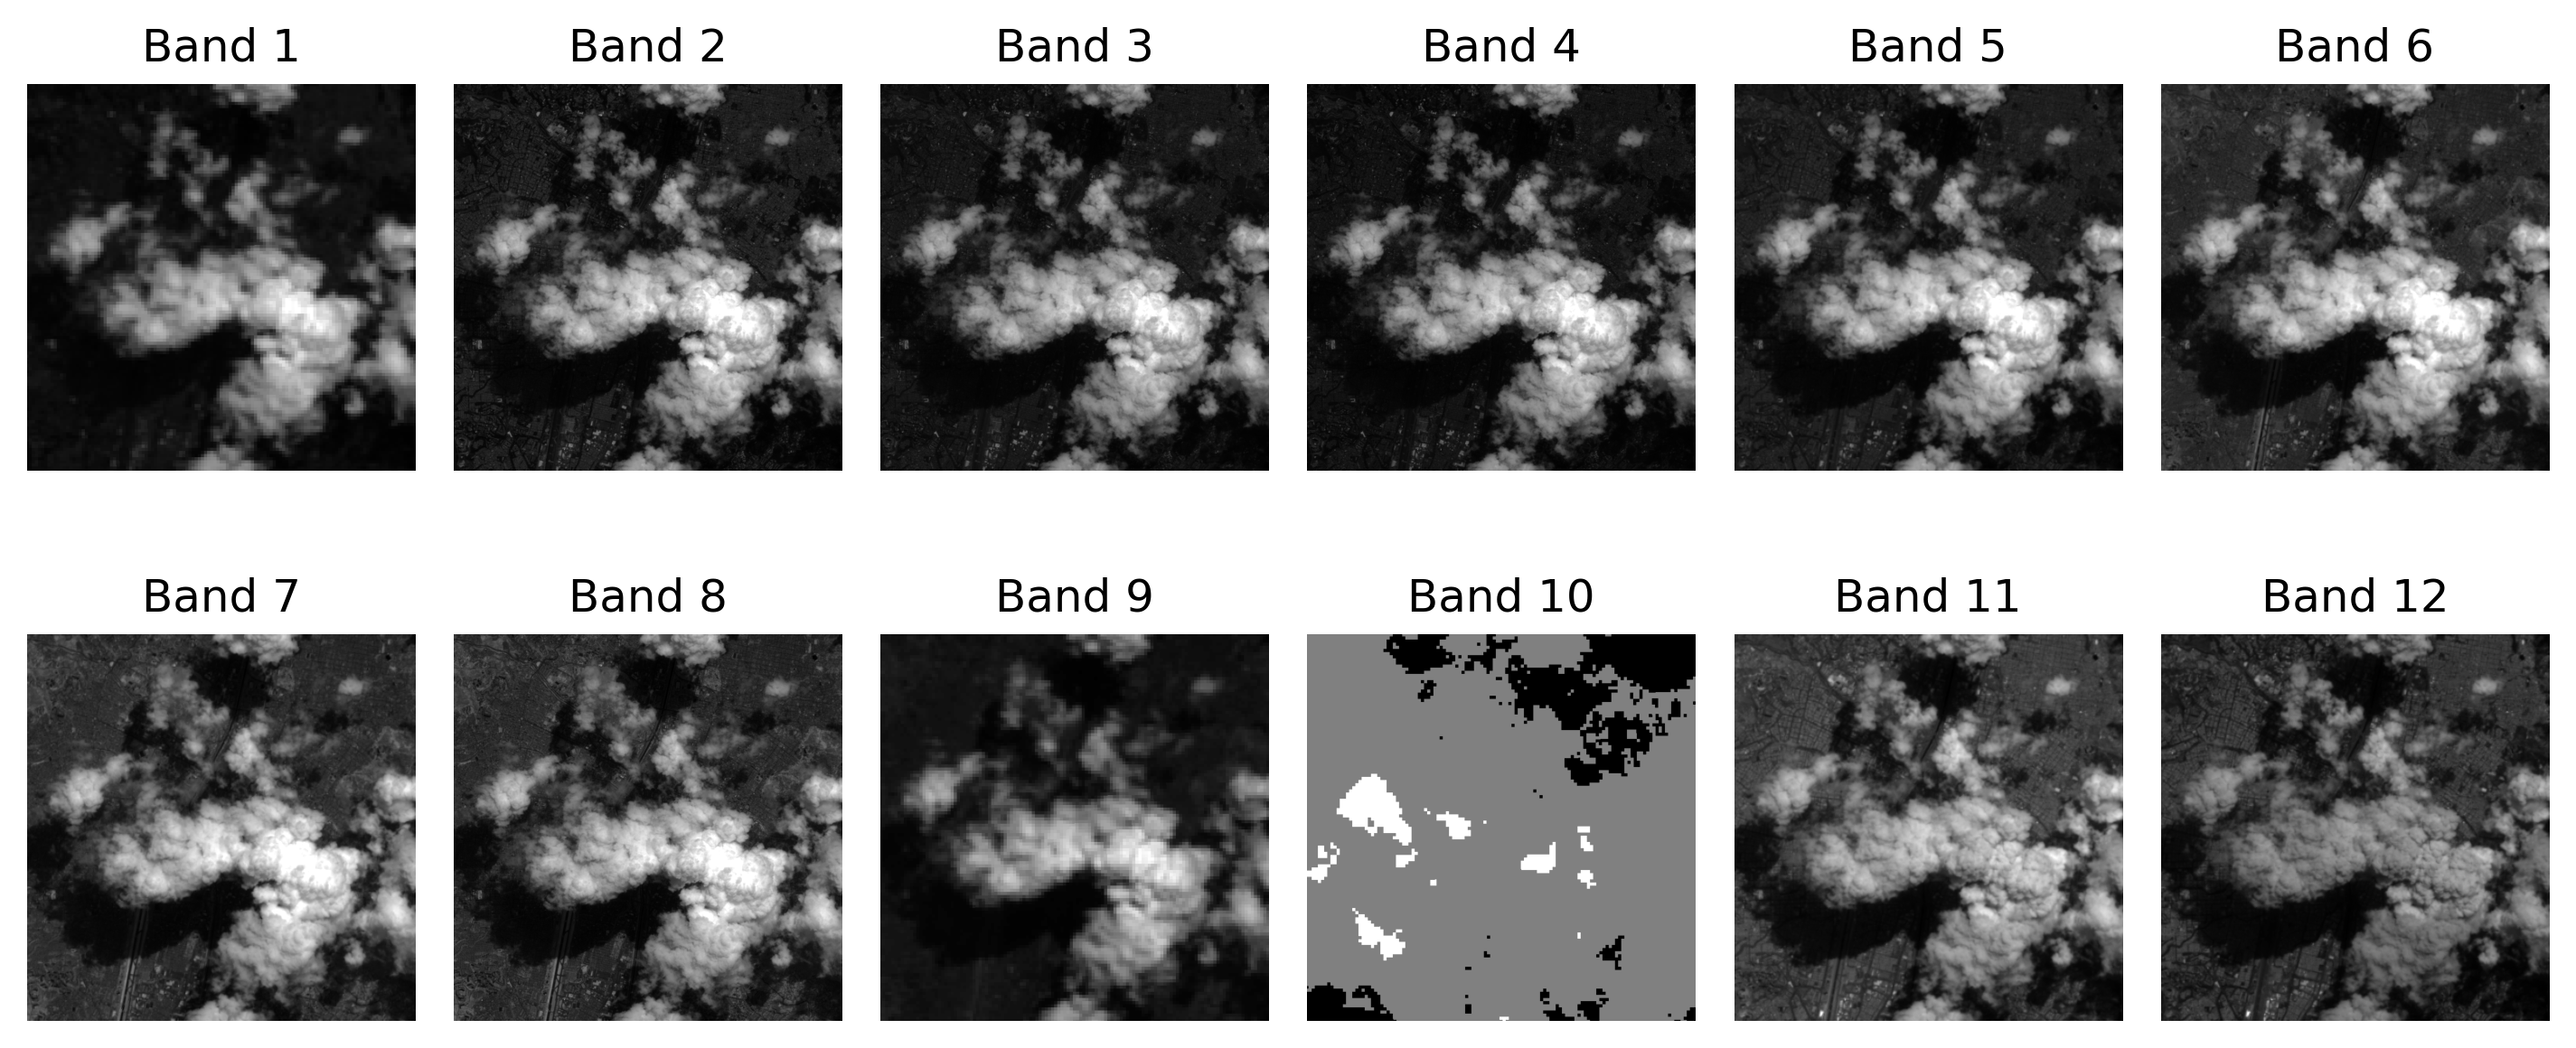

In [ ]:
city = '05001'
img_name = 'image_2016-06-12' 
img_path = os.path.join(img_folder, city, img_name + '.tiff')
print(img_path)

PlotAllBands(city, img_name, img_path, None)

# Show Medellin images

/content/drive/MyDrive/Prediction of Dengue Outbreak with Satellite Imagery/dataset/image/10_cities/05001/image_2018*
['/content/drive/MyDrive/Prediction of Dengue Outbreak with Satellite Imagery/dataset/image/10_cities/05001/image_2018-01-07.tiff'
 '/content/drive/MyDrive/Prediction of Dengue Outbreak with Satellite Imagery/dataset/image/10_cities/05001/image_2018-01-14.tiff'
 '/content/drive/MyDrive/Prediction of Dengue Outbreak with Satellite Imagery/dataset/image/10_cities/05001/image_2018-01-21.tiff'
 '/content/drive/MyDrive/Prediction of Dengue Outbreak with Satellite Imagery/dataset/image/10_cities/05001/image_2018-01-28.tiff'
 '/content/drive/MyDrive/Prediction of Dengue Outbreak with Satellite Imagery/dataset/image/10_cities/05001/image_2018-02-04.tiff'
 '/content/drive/MyDrive/Prediction of Dengue Outbreak with Satellite Imagery/dataset/image/10_cities/05001/image_2018-02-11.tiff'
 '/content/drive/MyDrive/Prediction of Dengue Outbreak with Satellite Imagery/dataset/image/10_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  if __name__ == '__main__':


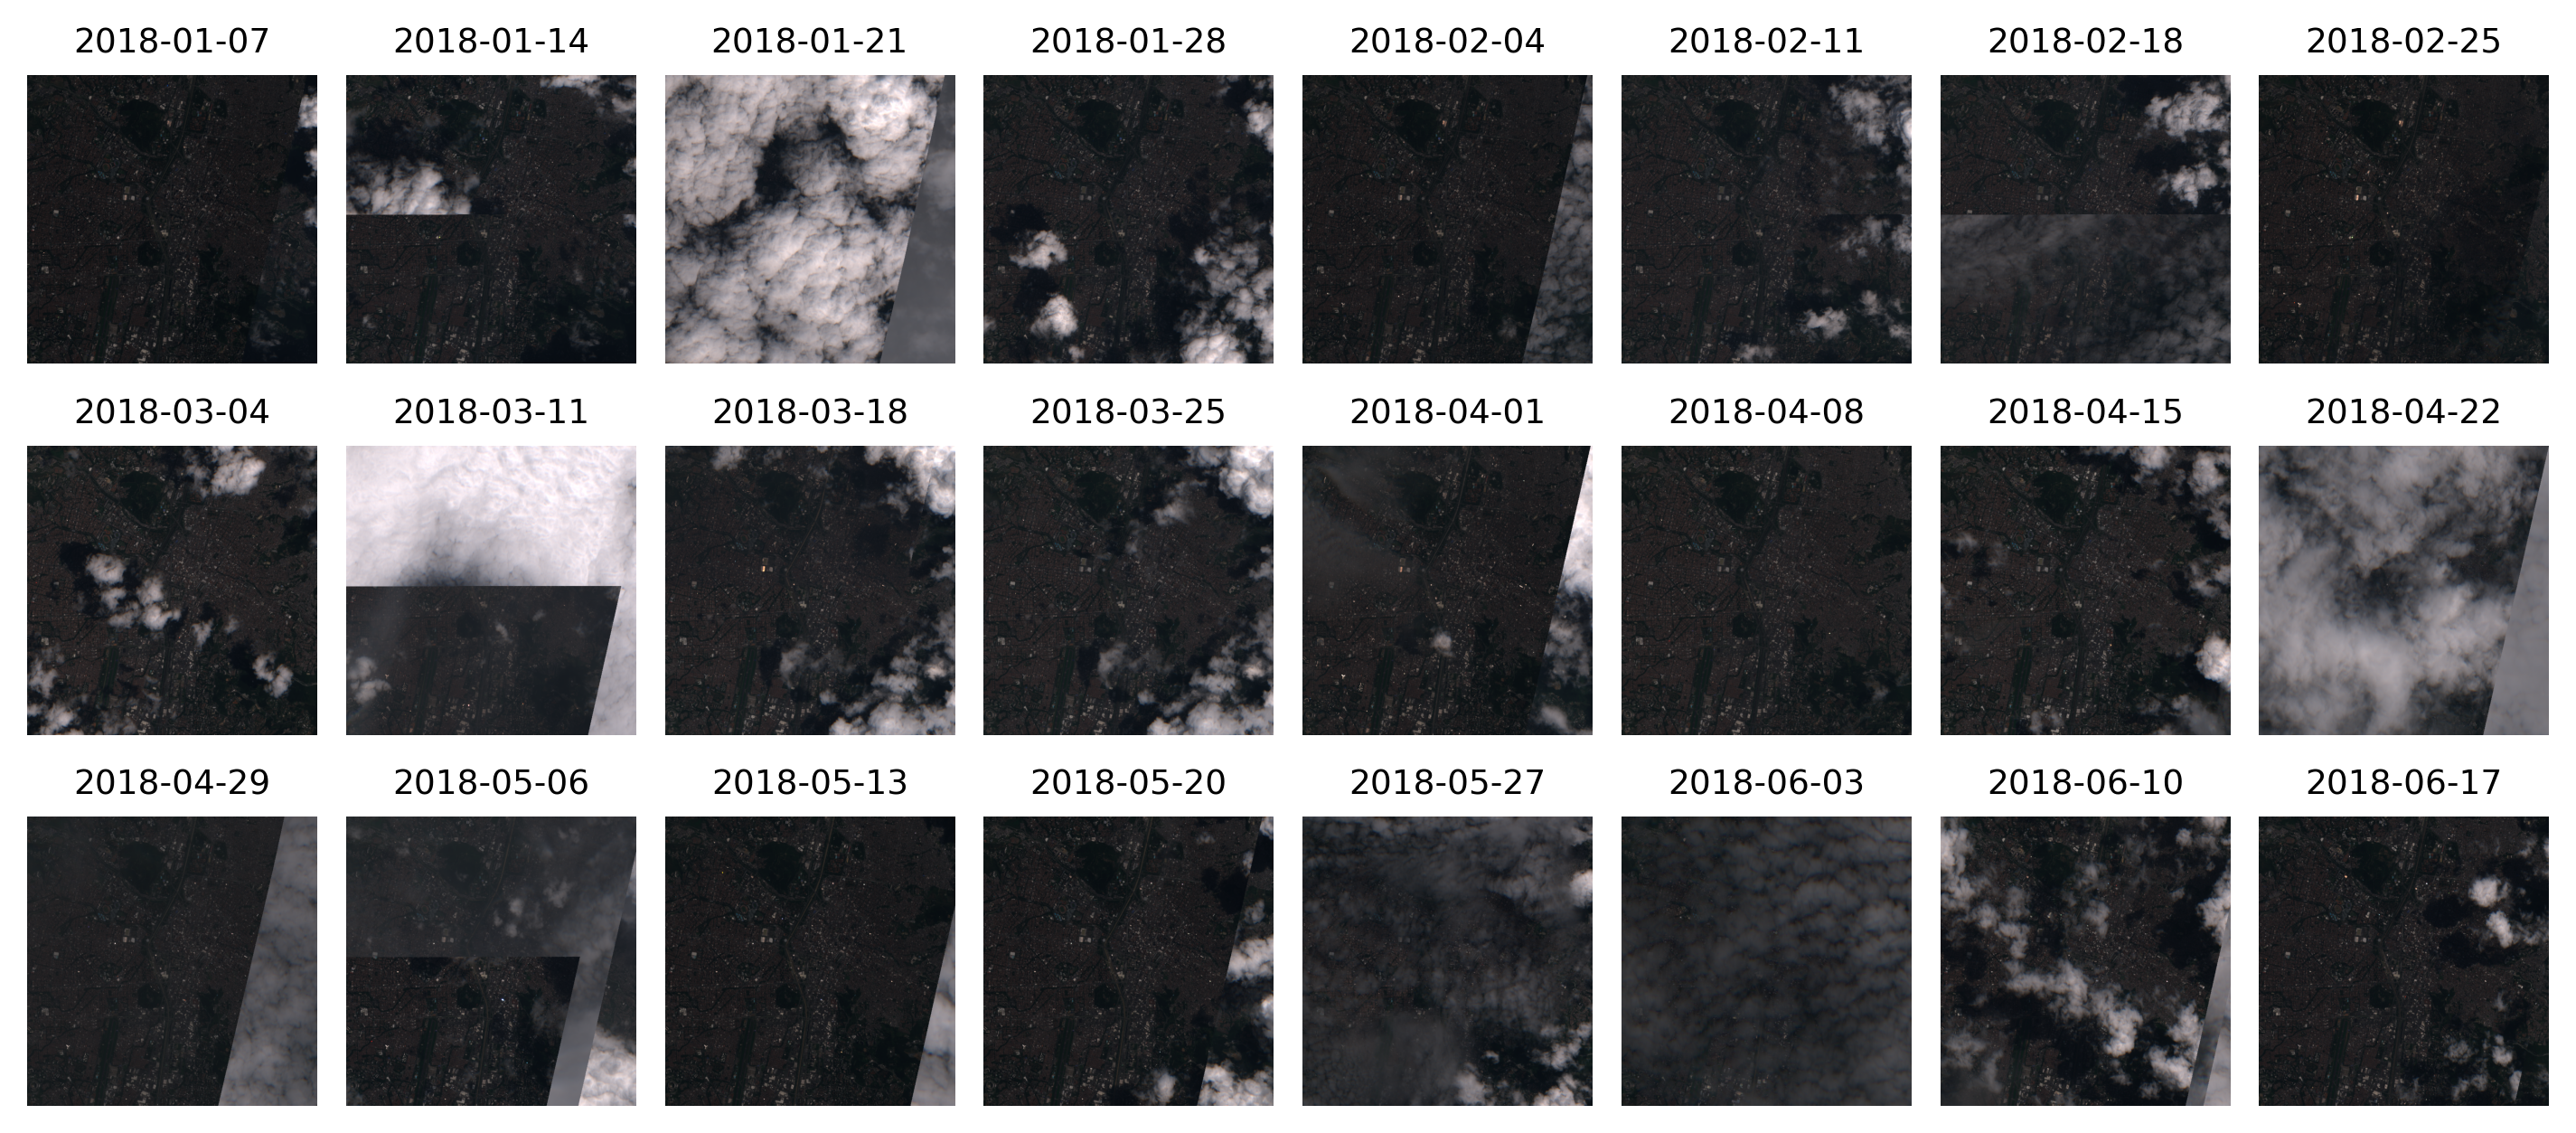

In [ ]:
path = str(img_folder / '05001/image_2018*')
print(path)
fig, axs = plt.subplots(3, 8, figsize=(12, 5), dpi=300,
                      constrained_layout = True)

files = glob.glob(path)
files = np.sort(np.array(files))
print(files)
plt.subplots_adjust(top=0.9, wspace=0.1, hspace=0.2)

for i, ax in enumerate(fig.get_axes()):
  origin_img = io.imread(files[i])
  selected_img = np.stack((origin_img[:, :, selected_three_bands[0]], 
                           origin_img[:, :, selected_three_bands[1]], 
                           origin_img[:, :, selected_three_bands[2]]))
  selected_img = np.transpose(selected_img, (1, 2, 0))
  ax.imshow(selected_img.astype(np.uint8))
  img_name = os.path.basename(files[i])[6:-5]
  ax.set_title(img_name, fontsize=9)
  ax.set_axis_off()

plt.show()